![vki_logo](https://www.skywin.be/sites/default/files/logo-membres/vki_logo_blue_rectangular.jpg)
### MODULO: A package for Multiscale Proper Orthogonal Decomposition
#### Tutorial 4: POD on non-uniform grids

This tutorial guides you through the steps needed to perform a POD decomposition on a non-uniform grid.
The database is formed of velocity fields that are exctracted from an unsteady CFD simulation of a jet impinging a flat plate (in OpenFOAM). 
The simulation is 3D but the data are extracted from a 2D slice, neglecting the (small) out-of-plane velocity component. 
The grid of this slice is non-uniform and the velocity fields are saved with constant time steps.


First, we import all the necessary libraries. Notes that we use the pyvista library to easily plot the non-uniform grid.
More info? https://docs.pyvista.org/version/stable/examples/99-advanced/openfoam-tubes.html

In [1]:
!pip install pyvista

In [2]:
import numpy as np
import pyvista as pv  
import pickle
import random
import matplotlib.pyplot as plt
import os
import urllib.request
from zipfile import ZipFile

# Default plot settings
camera_position = [(-0.004, 0.007, 0.03), (-0.004, 0.007, 0.0035), (-1, 0, 0)] # [camera position, focal point, view up direction]
font_size = 12

# Download files
FOLDER = 'Ex_8'
url = 'https://osf.io/aqkc8/download'
urllib.request.urlretrieve(url, 'Ex_8_2D_Impinging_JET_CFD.zip')
print('Download Completed! I prepare data Folder')
# Unzip the file
String = 'Ex_8_2D_Impinging_JET_CFD.zip'
zf = ZipFile(String, 'r')
zf.extractall('./')
zf.close()
os.rename('Ex_8_2D_Impinging_JET_CFD', FOLDER)  # rename the data flolder to FOLDER
os.remove(String)  # Delete the zip file with the data
print('Data set unzipped and ready ! ')


show_grid = True # 1 to show the grid when the domain is plot
folder_in_path = './Ex_8/'

Download Completed! I prepare data Folder
Data set unzipped and ready ! 


Let's load the data given in the folder "ex_04_data"!

In [4]:
# Velocity field
with open(folder_in_path + 'dataJet_uniform', 'rb') as f:
    Dat = pickle.load(f)

# UList is a list that contains the velocity field for each N_T time step
# Each velocity field is a 2D array MxN where
# M = number of vertices of the grid
# N = 2 = number of velocity components (i.e. horizontal and vertical)
UList  = Dat['U']

# Grid
# gridData is a PolyData object that contains all the info of the vtk grid 
gridData = pv.read(folder_in_path + 'grid.vtk')

We can have a look at the dataset. For example, let's look at the magnitude of the velocity field of the jet.

C:\Users\romai\Anaconda3\lib\site-packages\pyvista\jupyter\notebook.py:59: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  f'Failed to use notebook backend: \n\n{e}\n\nFalling back to a static output.'


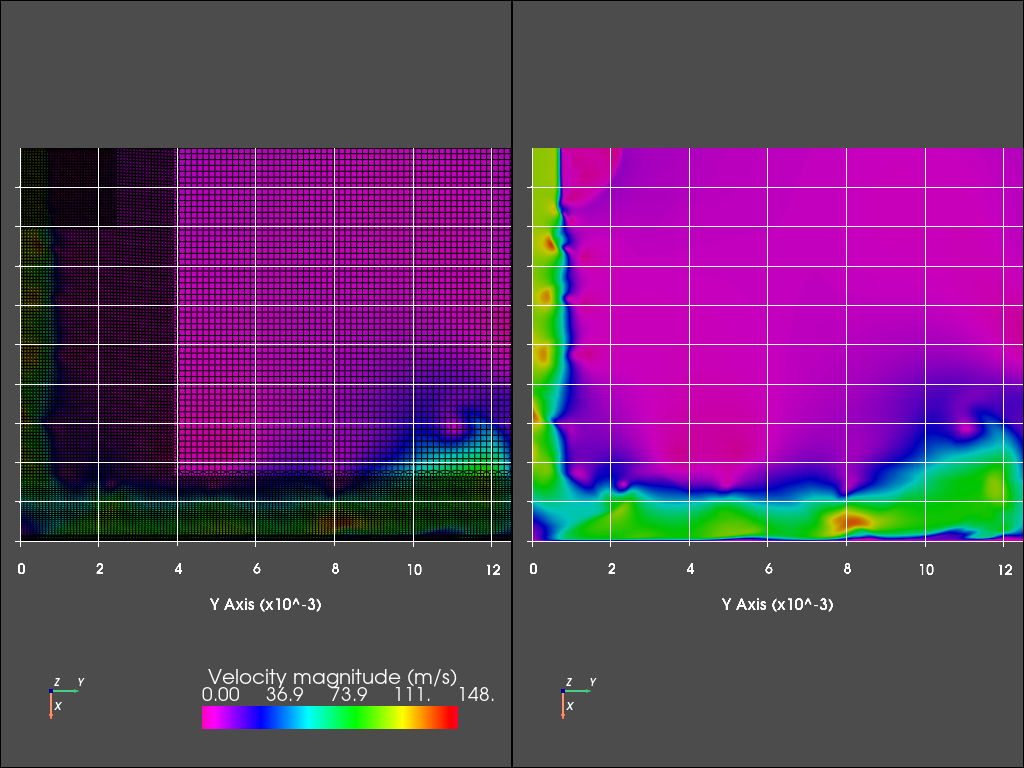

In [13]:
# Randoml pick of a time step
randSample = random.randint(0, len(UList))
gridData['Urandom']=UList[randSample].astype('float32')

# Fancy color map
cmap = plt.cm.gist_rainbow
cmap_reversed = plt.cm.get_cmap('gist_rainbow_r')

# Plot
camera_position_sub = [(-0.004, 0.006, 0.04), (-0.004, 0.006, 0.0035), (-1, 0, 0)] # [camera position, focal point, view up direction]
pl = pv.Plotter(shape=(1, 2))
pl.subplot(0, 0)
pl.add_mesh(gridData, scalars='Urandom', cmap=cmap_reversed,scalar_bar_args={'title': 'Velocity magnitude (m/s)'}, show_edges=True)
pl.show_axes_all()           # show frame
pl.show_grid(font_size=12)  
pl.camera_position =camera_position_sub
pl.subplot(0, 1)
pl.add_mesh(gridData, scalars='Urandom', cmap=cmap_reversed,scalar_bar_args={'title': 'Velocity magnitude (m/s)'}, show_edges=False)
pl.show_axes_all()         
pl.show_grid(font_size=12)  
pl.camera_position =camera_position_sub
pl.show()

The velocity fields were given at the cell vertices but the POD works with cell centre data matrices...
Let's compute the velocity field at the cell centers!

In [14]:
# Save the cell centres of the grid
cellCentres  = (gridData.cell_centers()).points

# Interpolate the velocity field from the cell vertices to the cell centers using pyvista functions
for i in range(len(UList)):
    gridData['U']=UList[i].astype('float32')            # Load the velocity field into the polyData object
    gridData_cC = gridData.point_data_to_cell_data()    # Interpolate U from the points to the cell centres
    UList[i] = gridData_cC['U']                         # Save the cell centres velocity field in the velocity list

Based on the velocity field list, we construct the D matrix as for the other tutorials.

In [15]:
N_S = cellCentres.shape[0]       # Number of grid points
N   = np.shape(UList[0])[1]      # Number of component of the u vectors (2 if 2D, 3 if 3D)
N_T = len(UList)                 # Number of time steps

D = np.zeros((N_S * N, N_T))

for i in range(N_T):
    tmp = UList[i]
    d_i = np.concatenate([tmp[:, 0], tmp[:, 1]], axis=0)
    D[:, i] = d_i #e.g. first colum: [u_x0y0 -> u_xkyk v_x0y0 -> v_xkyk]

Here comes the part specific to non-uniform grids.
As you know, K equals the dot product of the matrix D and its transpose (see previous tutorials). This was coded in the function "CorrelationMatrix" of _k_matrix.py as:

K = np.dot(D.T, D)

This is true only if the grid is uniform. If not, we must weigh the products by the normalised area of the cells.

Let's compute those weights!

C:\Users\romai\Anaconda3\lib\site-packages\pyvista\jupyter\notebook.py:59: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  f'Failed to use notebook backend: \n\n{e}\n\nFalling back to a static output.'


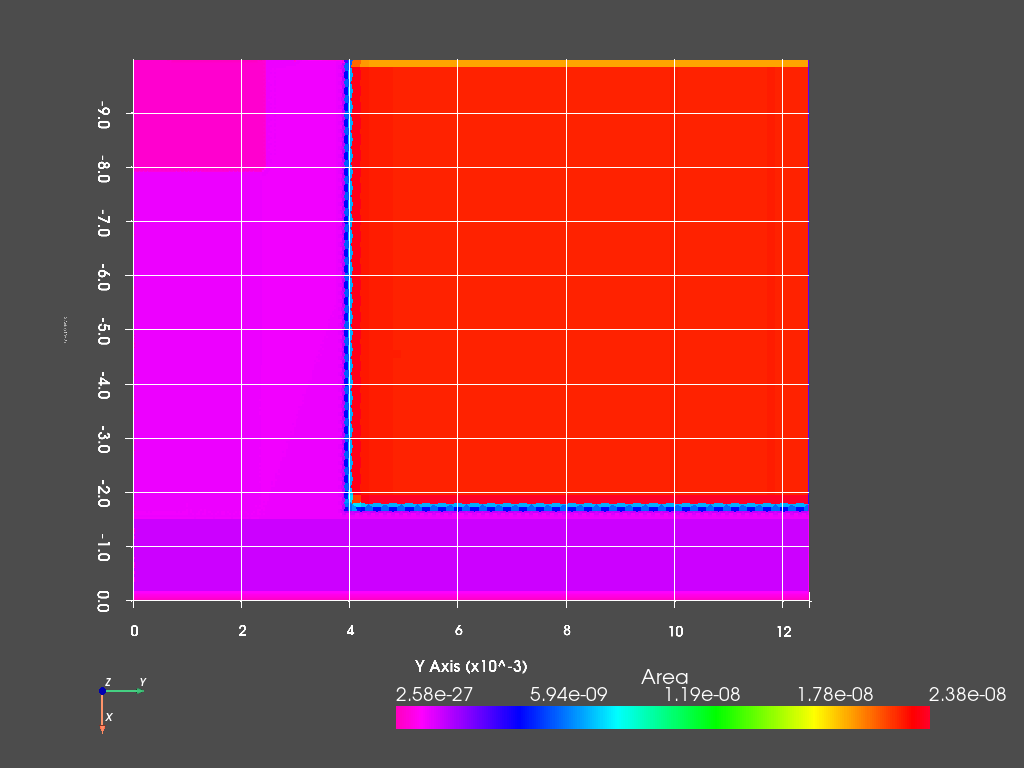

In [42]:
# Compute the area of each cell and save it into a vector of size N_S
a_dataSet = gridData.compute_cell_sizes()
area = a_dataSet['Area']

# Compute the weights
areaTot = np.sum(area)
weights = area/areaTot # sum should be equal to 1

# Duplicate the weights to match the length of D
weights_for_D = np.concatenate((weights,weights))

#Plot the area of each cell
gridData['area'] = area
pl = pv.Plotter()
pl.add_mesh(gridData, scalars='area',lighting=False, cmap=cmap_reversed,scalar_bar_args={'title': 'Area (m2)'}, show_edges=False)
pl.show_axes_all()           # show frame
pl.show_grid(font_size=12)  
pl.camera_position =camera_position
pl.show()

The weights are computed, the matrix D is formed... we give it to MODULO to compute the POD of the velocity field.

In [53]:
from modulo.modulo import MODULO

m = MODULO(data=D, n_Modes=5, dtype='float64',weights =weights_for_D)

Phi_POD, Psi_POD, Sigma_POD = m.compute_POD_K()

TypeError: __init__() got an unexpected keyword argument 'weights'

Interest coders can look in the initialisation of MODULO. There we check whether the user has prodived an array with the weights. 
- If not, then we assume the users has provided a uniform grid. 
- If yes, then we multiply each element of D by its respective weights and call this result "Dstar". For example, the first column of Dstar is: 
    Dstar[:,0] = [D[0,0]*sqrt(w[0,0]), D[1,0]*sqrt(w[1,0]), ..., D[2*N_s,0]*sqrt(w[2*N_s,0])]
This Dstar matrix is then used to compute K.

Finally, we plot the first modes.

In [ ]:
# Select the number of modes you want to plot
nMode_toPlot = 2

# Half the length of Phi_POD equals the length of the U and V vectors
nxny=int(len(Phi_POD[:,0])/2)

# Plot using pyvista
Phi_w_0 = np.zeros((nxny,1))  # dummy mode used only to please the plot function
print("Close to end the execution")
pl = pv.Plotter(shape=(nMode_toPlot, 2))
for i in range(nMode_toPlot):
    Phi_u_0 = (Phi_POD[:nxny, i]).reshape(-1, 1)
    Phi_v_0 = (Phi_POD[nxny:, i]).reshape(-1, 1)

    gridData['UV_POD'] = np.hstack((Phi_u_0, Phi_v_0, Phi_w_0))
    # X velocity
    pl.subplot(i, 0)
    pl.add_mesh(gridData, scalars=gridData['UV_POD'][:, 0],copy_mesh=True,show_edges=False)
    pl.show_grid(font_size=font_size)
    pl.camera_position =camera_position
    pl.add_title('POD Mode {}: U'.format(i+1), font='times', color='k', font_size=font_size)
    # Y velocity
    pl.subplot(i, 1)
    pl.add_mesh(gridData, scalars=gridData['UV_POD'][:, 1],copy_mesh=True,show_edges=False)
    pl.show_grid(font_size=font_size)
    pl.camera_position =camera_position
    pl.add_title('POD Mode {}: V'.format(i+1), font='times', color='k', font_size=font_size)
pl.show()